## Домашнее задание Кошкиной Ксении

## Домашнее задание 3
### RNN архитектуры 


В этой домашке будем разбираться с RNN и учиться работать со статьями, я нашла для вас вот такую достаточно уже старую, но при этом несложно написанную, статью с хорошо описанными экспериментами, в современных реалиях, она конечно не state of the art, но она хорошо подойдет для наших целей. 
1) прочитайте статью https://arxiv.org/pdf/1511.08630.pdf
2) мы будем ставить эксперименты на других данных, поэтому, проанализируйте и сделайте препроцессинг на основании вашего анализа и того дизайна экспериментов, который описан в статье, для этого датасета https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv 

Задача: предсказать категорию новости (там есть дополнительная колонка, не обращаем внимание, что это датасет fakenews, в этом дз нас интересует тематика новости)
3) реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с разными гиперпараметрами, разными способами регуляризации, описанными в статье (в том числе, чтобы можно было вставлять ее в разных местах), паддингом, векторизацией.  
4) поставьте эксперименты с разными параметрами и особенностями архитектуры (регуляризация, паддинг, векторизация, драпаут и тд, в статье подробно описан смысл этих операций и что конкретно делали, загуглите как это имплементировано в торче) так как описано в статье (там есть подробное описание в разделе 5.2 Experimental Settings )
5) оцените результаты экспериментов также, как это сделали в статье 
6) напишите выводы (это должно быть похоже на раздел Results and Model Analysis только не нужно сравнивать с другими моделями, как это делают авторы статьи, сравнивайте только результаты своих экспериментов, потому что там цифры на других датасетах. Да писать так много тоже не нужно, но у вас и должно получиться меньше потому что не будет сравнения)


Если вы хотите дополнительный балл:
1) реализуйте классы для RNN, LSTM и GRU ячейки 
2) реализуйте класс RNN слоя

Если вы хотите еще один дополнительный балл, то используйте в экспериментах не RNN слой из торча, а свой самочинный слой, с разными типами ячеек (то есть поставьте дополнительные эксперименты не только с LSTM слоем, но и с обычным RNN и GRU слоем) 

In [1]:
! pip install torchmetrics

     |████████████████████████████████| 332 kB 5.2 MB/s 


In [2]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
from collections import Counter
from torch.optim import RMSprop
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from string import punctuation
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.nn.functional as F
from torchmetrics.functional import f1, recall, accuracy
from torch.nn.utils.rnn import pad_sequence
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
DEVICE = device

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Fake.csv')

In [7]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
def preprocessing(text):
  text = word_tokenize(text.lower())
  return text

In [9]:
data['preprocess_text'] = [preprocessing(x) for x in data['text'].tolist()]

In [10]:
data.head()

,title,text,subject,date,preprocess_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ..."


In [11]:
data['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

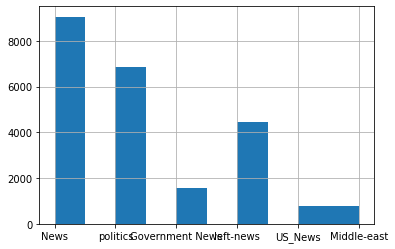

In [12]:
data['subject'].hist()

In [13]:
data['sub'] = data['subject'].astype('category').cat.codes

In [14]:
data.head()

,title,text,subject,date,preprocess_text,sub
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, just, couldn, t, wish, all, am...",2
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",2
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, ,, it, was, revealed, that, forme...",2
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017","[on, christmas, day, ,, donald, trump, announc...",2
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017","[pope, francis, used, his, annual, christmas, ...",2


In [15]:
datas = data[['preprocess_text','sub']]

In [16]:
train_data, test_data = train_test_split(datas, test_size=0.2,shuffle=True, random_state=seed)

In [17]:
vocab = Counter()

for text in datas['preprocess_text']:
    vocab.update(text)
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 181384


In [18]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 3:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 3 раз:', len(filtered_vocab))

уникальных токенов, втретившихся больше 3 раз: 48322


In [19]:
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'UNK':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [20]:
len(word2id)

48323

In [21]:
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

In [22]:
MAX_LEN = 0

for text in data.preprocess_text:
    MAX_LEN = max(len(text), MAX_LEN)
MAX_LEN

9938

Уменьшаем длину, потому максимальная длина слишком длинная


In [23]:
MAX_LEN = 200

In [24]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 21:23:59--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.206.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.206.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  63.0MB/s    in 25s     

2021-12-29 21:24:23 (63.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [25]:
import gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [26]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items(): 
    try:
        weights[i] = w2v[word]    
    except KeyError:
        weights[i] = np.random.normal(0,0.1,300)

In [27]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = datas['preprocess_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(data['sub'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        ids = F.pad(ids, (0, MAX_LEN - len(ids)))
        y = self.target[index]
        return ids, y

In [28]:
train_dataset = MyDataset(train_data, word2id, DEVICE)
train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=64)

In [29]:
val_dataset = MyDataset(test_data, word2id, DEVICE)
val_iterator = DataLoader(val_dataset, shuffle=True, batch_size=64)

In [114]:
import numpy as np


class C_LSTM(nn.Module):


  def __init__(self, max_len, filter_sizes, vocab_size, 
                 embedding_dim, filter_num, drop, hidden, 
                 num_layers, weights, dropout_number):
    super().__init__()
    self.vocab_size = vocab_size 
    self.max_len = max_len
    self.filter_sizes = filter_sizes  
    self.filter_number = filter_num
    self.drop = drop
    self.hidden = hidden
    self.num_layers = num_layers
    self.dropout_number = dropout_number

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.from_pretrained(torch.tensor(weights)) 

    c_layers = []
    for size in filter_sizes:
      conv = nn.Conv1d(in_channels=embedding_dim,
                       out_channels=filter_num,
                       kernel_size=size)
      c_layers.append(conv)
    self.c_layers = nn.ModuleList(c_layers)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=self.dropout_number)
    self.softmax = nn.Softmax(dim=1)

    self.lstm = nn.LSTM(input_size=self.filter_number*self.num_layers,
                        hidden_size=self.hidden, 
                        num_layers=self.num_layers, 
                        batch_first=True)

    self.linear = nn.Linear(self.hidden, 6)

  def forward(self, word):
    embedded = self.embedding(word)
    if self.drop == 'first':
      embedded = self.dropout(embedded)
    embedded = embedded.transpose(1, 2)

    max_feature_len = self.max_len - max(self.filter_sizes) + 1  
    out = []
    for c in self.c_layers:
      feature = c(embedded)
      feature = self.relu(c(embedded)).transpose(1,2)
      feature = feature[:, :, :max_feature_len]
      out.append(feature)
    
    if len(self.filter_sizes) > 1:
      input = torch.cat(out, 1)
    else:
      input = feature
            
    _, (state, _) = self.lstm(input)
    if self.drop == 'last':
      embedded = self.dropout(embedded)
    logits = self.softmax(self.linear(torch.squeeze(state, 0)))
    return logits 

In [115]:
def train(model, iterator, optimizer, criterion, metric, device):
    print('Training...')
    epoch_loss = 0 
    epoch_metric = 0
    model.train()  

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        texts = texts.to(device)
        ys = ys.to(device)
        preds = model(texts.squeeze())  
        loss = criterion(preds, ys.long())   
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item() 
        
        batch_metric = metric(preds, ys.long(), ignore_index=0)
        epoch_metric += batch_metric   
        if not (i + 1) % 100:
              pass
              print(f'Train f1: {epoch_metric / len(iterator)}, Train loss: {epoch_loss / len(iterator)}') 
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [116]:
def evaluate(model, iterator, criterion, metric, device):
    print("\nValidating...")
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):  
            texts = texts.to(device)
            ys = ys.to(device) 
            preds = model(texts.squeeze()) 
            loss = criterion(preds, ys.long())   
            epoch_loss += loss.item()
            batch_metric = metric(preds, ys.long(), ignore_index=0)
            epoch_metric += batch_metric
            if not (i + 1) % 100:
              pass

              print(f'Val f1_ev: {epoch_metric / len(iterator)}, Val loss_ev: {epoch_loss / len(iterator)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [117]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

In [118]:
#drop=first #filter=[2]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [120]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.21471281349658966, Train loss: 0.4888237536358995
Train f1: 0.4262188971042633, Train loss: 0.9809901689996525

Validating...

starting Epoch 2
Training...
Train f1: 0.17576605081558228, Train loss: 0.5268499125428752
Train f1: 0.38197699189186096, Train loss: 1.0242209020926027

Validating...

starting Epoch 3
Training...
Train f1: 0.2015848308801651, Train loss: 0.5018274431325951
Train f1: 0.33164942264556885, Train loss: 1.0723008497231672

Validating...

starting Epoch 4
Training...
Train f1: 0.12910494208335876, Train loss: 0.5713258924938384
Train f1: 0.26565316319465637, Train loss: 1.1360249811289262

Validating...

starting Epoch 5
Training...
Train f1: 0.13087496161460876, Train loss: 0.56984883952303
Train f1: 0.25970277190208435, Train loss: 1.1415435728572665

Validating...

starting Epoch 6
Training...
Train f1: 0.13585907220840454, Train loss: 0.564694341348142
Train f1: 0.31661856174468994, Train loss: 1.0843906017387805

Valid

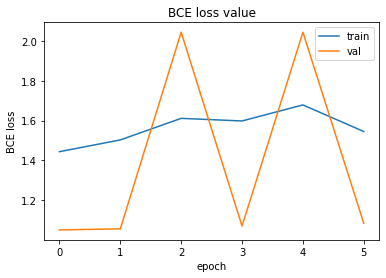

In [121]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

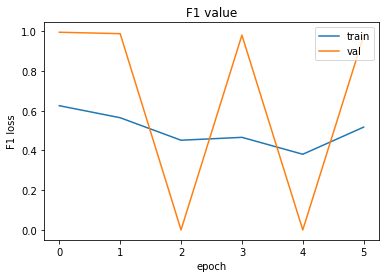

In [122]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [123]:
#drop=first #filter=[3]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[3], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [124]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.2118476927280426, Train loss: 0.4924067157466395
Train f1: 0.4226987361907959, Train loss: 0.9859246591321466

Validating...

starting Epoch 2
Training...
Train f1: 0.2153751105070114, Train loss: 0.48790231245715604
Train f1: 0.426213800907135, Train loss: 0.9813003195386355

Validating...

starting Epoch 3
Training...
Train f1: 0.21050794422626495, Train loss: 0.4934758292574461
Train f1: 0.42468616366386414, Train loss: 0.983345489518172

Validating...

starting Epoch 4
Training...
Train f1: 0.21554303169250488, Train loss: 0.48848891460976634
Train f1: 0.42698681354522705, Train loss: 0.9813884310170907

Validating...

starting Epoch 5
Training...
Train f1: 0.2158043533563614, Train loss: 0.48839945047080113
Train f1: 0.42826271057128906, Train loss: 0.9797236651790385

Validating...

starting Epoch 6
Training...
Train f1: 0.21214549243450165, Train loss: 0.49196080042391405
Train f1: 0.4279870092868805, Train loss: 0.9800038937808705

Vali

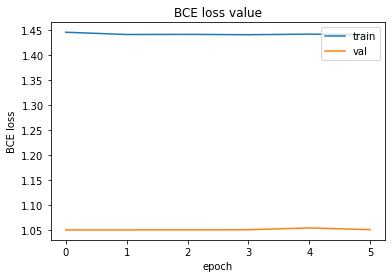

In [125]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

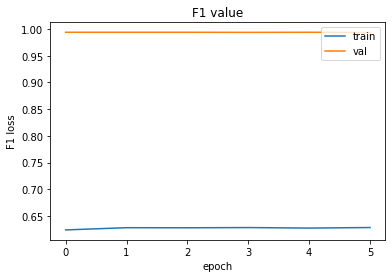

In [126]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [127]:
#drop=first #filter=[4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [128]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.18135426938533783, Train loss: 0.518822501711294
Train f1: 0.3935111463069916, Train loss: 1.0104914538714351

Validating...

starting Epoch 2
Training...
Train f1: 0.20594355463981628, Train loss: 0.49755276709186785
Train f1: 0.36029478907585144, Train loss: 1.045268009309055

Validating...

starting Epoch 3
Training...
Train f1: 0.21361225843429565, Train loss: 0.48885155818900283
Train f1: 0.398335725069046, Train loss: 1.0064172314948776

Validating...

starting Epoch 4
Training...
Train f1: 0.19212888181209564, Train loss: 0.510213744072687
Train f1: 0.39264360070228577, Train loss: 1.0112910335566723

Validating...

starting Epoch 5
Training...
Train f1: 0.214480459690094, Train loss: 0.4881396634238107
Train f1: 0.4252433776855469, Train loss: 0.9808247876005108

Validating...

starting Epoch 6
Training...
Train f1: 0.21469154953956604, Train loss: 0.4871110749893448
Train f1: 0.4302690923213959, Train loss: 0.9752006445612226

Validati

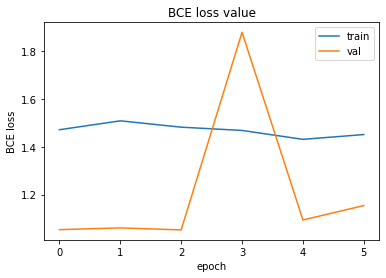

In [129]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

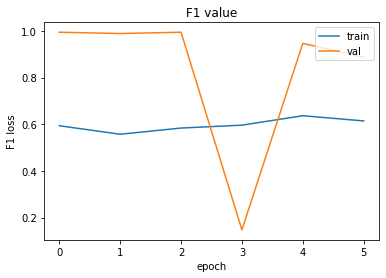

In [130]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [131]:
#drop=first #filter=[2,3]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2,3], vocab_size=len(word2id),
               embedding_dim=300, filter_num=2, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [132]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.18904444575309753, Train loss: 0.5115223559392553
Train f1: 0.3995281159877777, Train loss: 1.0052164529456573

Validating...

starting Epoch 2
Training...
Train f1: 0.19120796024799347, Train loss: 0.5115004125095549
Train f1: 0.38515985012054443, Train loss: 1.0207526647314733

Validating...

starting Epoch 3
Training...
Train f1: 0.20231641829013824, Train loss: 0.5006705814478348
Train f1: 0.41057443618774414, Train loss: 0.9958750216328368

Validating...

starting Epoch 4
Training...
Train f1: 0.21229474246501923, Train loss: 0.4912447978039177
Train f1: 0.4261966347694397, Train loss: 0.9802958284105573

Validating...

starting Epoch 5
Training...
Train f1: 0.21287988126277924, Train loss: 0.4901310400087006
Train f1: 0.4278392195701599, Train loss: 0.9792349431790462

Validating...

starting Epoch 6
Training...
Train f1: 0.20491336286067963, Train loss: 0.49822398837731807
Train f1: 0.42553281784057617, Train loss: 0.9810622156071825

Va

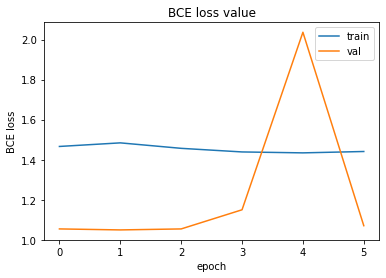

In [133]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

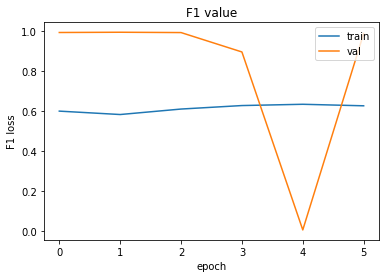

In [134]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [135]:
#drop=first #filter=[3,4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[3,4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=2, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [136]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.21158307790756226, Train loss: 0.4928822959361433
Train f1: 0.424875944852829, Train loss: 0.9838745792706808

Validating...

starting Epoch 2
Training...
Train f1: 0.21522599458694458, Train loss: 0.48954803684130815
Train f1: 0.42999735474586487, Train loss: 0.9784375048008095

Validating...

starting Epoch 3
Training...
Train f1: 0.21624818444252014, Train loss: 0.4878117892206932
Train f1: 0.4263395667076111, Train loss: 0.982038829196878

Validating...

starting Epoch 4
Training...
Train f1: 0.21576619148254395, Train loss: 0.4882913669761346
Train f1: 0.4306783974170685, Train loss: 0.9769892684456443

Validating...

starting Epoch 5
Training...
Train f1: 0.2107199877500534, Train loss: 0.4931899061819323
Train f1: 0.42721128463745117, Train loss: 0.9807494984192102

Validating...

starting Epoch 6
Training...
Train f1: 0.2159075289964676, Train loss: 0.48781968663338904
Train f1: 0.43154630064964294, Train loss: 0.9761151533548523

Valid

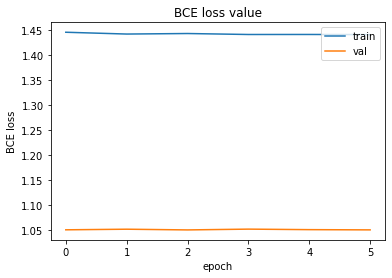

In [137]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

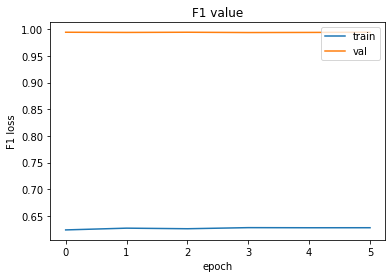

In [138]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [139]:
#drop=first #filter=[2,3,4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2,3,4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=3, drop='first', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [140]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.21280838549137115, Train loss: 0.4916727453672967
Train f1: 0.4251651167869568, Train loss: 0.9834270870604482

Validating...

starting Epoch 2
Training...
Train f1: 0.21224993467330933, Train loss: 0.49083625621536153
Train f1: 0.4264892339706421, Train loss: 0.9811464933311047

Validating...

starting Epoch 3
Training...
Train f1: 0.21310342848300934, Train loss: 0.49066454537060794
Train f1: 0.4272598922252655, Train loss: 0.9806973516535596

Validating...

starting Epoch 4
Training...
Train f1: 0.2143711894750595, Train loss: 0.4892295813884865
Train f1: 0.42853859066963196, Train loss: 0.9787610801709753

Validating...

starting Epoch 5
Training...
Train f1: 0.21641585230827332, Train loss: 0.48745338000407834
Train f1: 0.42728206515312195, Train loss: 0.9806739898765979

Validating...

starting Epoch 6
Training...
Train f1: 0.21552595496177673, Train loss: 0.4887404186385019
Train f1: 0.427407443523407, Train loss: 0.9803791285372104

Val

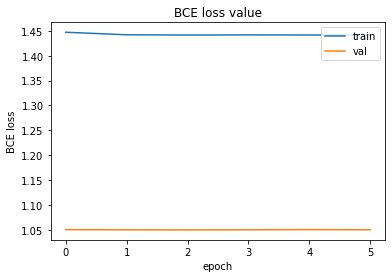

In [141]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

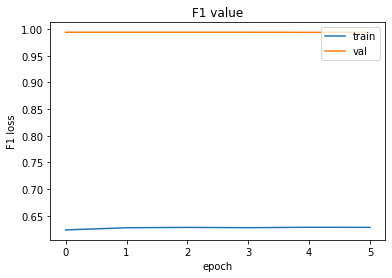

In [142]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [143]:
#drop=last #filter=[2]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [145]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.2265556901693344, Train loss: 0.477355314760792
Train f1: 0.44888460636138916, Train loss: 0.9588205031797189

Validating...

starting Epoch 2
Training...
Train f1: 0.21357835829257965, Train loss: 0.48929717183924043
Train f1: 0.4326975643634796, Train loss: 0.974378436195607

Validating...

starting Epoch 3
Training...
Train f1: 0.18188460171222687, Train loss: 0.5206770446835732
Train f1: 0.36356818675994873, Train loss: 1.0414122955328753

Validating...

starting Epoch 4
Training...
Train f1: 0.17146721482276917, Train loss: 0.5302102269769526
Train f1: 0.30192306637763977, Train loss: 1.100257041502972

Validating...

starting Epoch 5
Training...
Train f1: 0.15922914445400238, Train loss: 0.5425086329583408
Train f1: 0.36585375666618347, Train loss: 1.0384257346594414

Validating...

starting Epoch 6
Training...
Train f1: 0.21541425585746765, Train loss: 0.4880050858672784
Train f1: 0.4332275092601776, Train loss: 0.9734950552181322

Valid

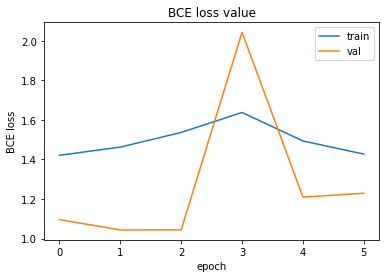

In [146]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

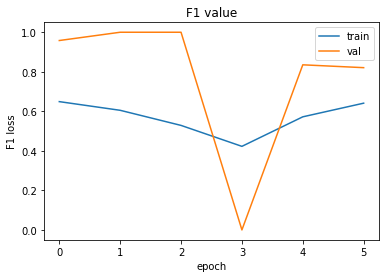

In [147]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [148]:
#drop=last #filter=[3]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[3], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [149]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.18910354375839233, Train loss: 0.5103675767677982
Train f1: 0.401265412569046, Train loss: 1.0028567038425782

Validating...

starting Epoch 2
Training...
Train f1: 0.21294265985488892, Train loss: 0.4905381587897839
Train f1: 0.42572665214538574, Train loss: 0.9817458091138982

Validating...

starting Epoch 3
Training...
Train f1: 0.2135477513074875, Train loss: 0.49037613998464985
Train f1: 0.4297671318054199, Train loss: 0.9773661392886622

Validating...

starting Epoch 4
Training...
Train f1: 0.2151133120059967, Train loss: 0.48852938819093766
Train f1: 0.4309217035770416, Train loss: 0.9756634069137833

Validating...

starting Epoch 5
Training...
Train f1: 0.21749666333198547, Train loss: 0.4860300900173836
Train f1: 0.4349563717842102, Train loss: 0.9716950257619222

Validating...

starting Epoch 6
Training...
Train f1: 0.21179355680942535, Train loss: 0.491519688748989
Train f1: 0.34426844120025635, Train loss: 1.059893858676054

Validat

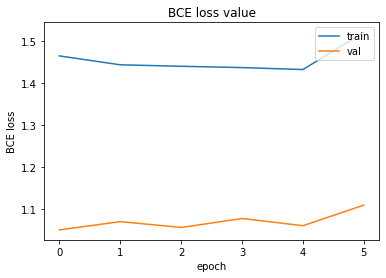

In [150]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

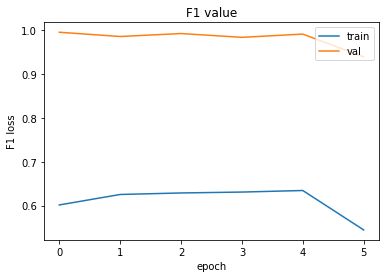

In [151]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [152]:
#drop=last #filter=[4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=1, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [153]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.2085001915693283, Train loss: 0.49589986866023267
Train f1: 0.41979074478149414, Train loss: 0.9887768090987692

Validating...

starting Epoch 2
Training...
Train f1: 0.2148430198431015, Train loss: 0.4890457010593544
Train f1: 0.42826220393180847, Train loss: 0.9801106732718798

Validating...

starting Epoch 3
Training...
Train f1: 0.2127341479063034, Train loss: 0.4912679799559976
Train f1: 0.42552289366722107, Train loss: 0.9825738660332297

Validating...

starting Epoch 4
Training...
Train f1: 0.21503780782222748, Train loss: 0.48851853771274595
Train f1: 0.4279383718967438, Train loss: 0.9797252444993882

Validating...

starting Epoch 5
Training...
Train f1: 0.21145367622375488, Train loss: 0.49245531137297754
Train f1: 0.42743727564811707, Train loss: 0.980774530342647

Validating...

starting Epoch 6
Training...
Train f1: 0.21175803244113922, Train loss: 0.4922168469753395
Train f1: 0.4297250807285309, Train loss: 0.9786693534883512

Val

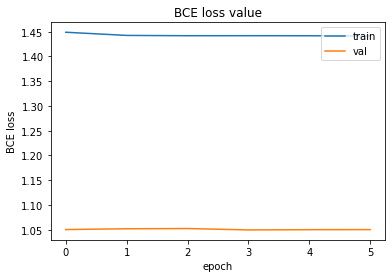

In [154]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

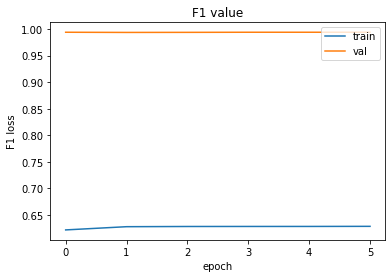

In [155]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [156]:
#drop=last #filter=[2,3]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2,3], vocab_size=len(word2id),
               embedding_dim=300, filter_num=2, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [157]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.20099295675754547, Train loss: 0.5029096011401845
Train f1: 0.3894520103931427, Train loss: 1.0171922595322538

Validating...

starting Epoch 2
Training...
Train f1: 0.20956328511238098, Train loss: 0.4940379022740993
Train f1: 0.4272407293319702, Train loss: 0.979498127285315

Validating...

starting Epoch 3
Training...
Train f1: 0.21679319441318512, Train loss: 0.4859672144156735
Train f1: 0.4374711811542511, Train loss: 0.9685811242278741

Validating...

starting Epoch 4
Training...
Train f1: 0.21922726929187775, Train loss: 0.48462861046499134
Train f1: 0.44506117701530457, Train loss: 0.9617856959907376

Validating...

starting Epoch 5
Training...
Train f1: 0.2203906774520874, Train loss: 0.48261446409484965
Train f1: 0.44668111205101013, Train loss: 0.959465982557154

Validating...

starting Epoch 6
Training...
Train f1: 0.22845207154750824, Train loss: 0.4738038575568167
Train f1: 0.44645363092422485, Train loss: 0.9597398095390424

Vali

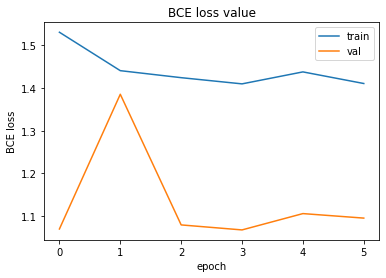

In [158]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

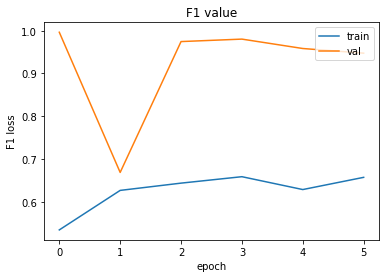

In [159]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [160]:
#drop=last #filter=[3,4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[3,4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=2, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [161]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.20706848800182343, Train loss: 0.49740657068434213
Train f1: 0.4242780804634094, Train loss: 0.9841037084456203

Validating...

starting Epoch 2
Training...
Train f1: 0.21462173759937286, Train loss: 0.48984897542162004
Train f1: 0.42774444818496704, Train loss: 0.9806639750798544

Validating...

starting Epoch 3
Training...
Train f1: 0.2144874632358551, Train loss: 0.48961979677888
Train f1: 0.42948728799819946, Train loss: 0.9782752135172993

Validating...

starting Epoch 4
Training...
Train f1: 0.2134481817483902, Train loss: 0.49069369650211464
Train f1: 0.42618483304977417, Train loss: 0.9817978703245824

Validating...

starting Epoch 5
Training...
Train f1: 0.21197983622550964, Train loss: 0.4916548295085933
Train f1: 0.42624667286872864, Train loss: 0.9821645905371426

Validating...

starting Epoch 6
Training...
Train f1: 0.21584944427013397, Train loss: 0.4878792264023606
Train f1: 0.42753660678863525, Train loss: 0.9801406138608245

Va

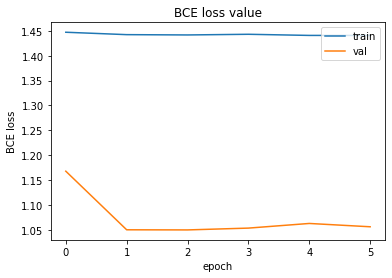

In [162]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

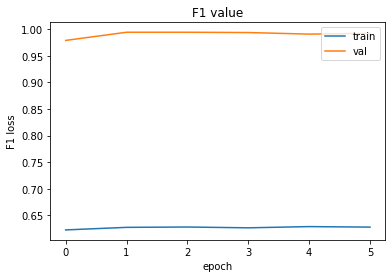

In [163]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [164]:
#drop=last #filter=[2,3,4]
model = C_LSTM(max_len=MAX_LEN, filter_sizes=[2,3,4], vocab_size=len(word2id),
               embedding_dim=300, filter_num=3, drop='last', 
               hidden=150, num_layers=1, weights=weights, dropout_number=0.5) 
optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)

In [165]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(6):
    print(f'\nstarting Epoch {i+1}')
    f1_value, epoch_loss = train(model, train_iterator, optimizer, criterion, f1, DEVICE)
    losses.append(epoch_loss)
    f1s.append(f1_value)

    f1_value_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, f1, DEVICE)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_value_on_test)


starting Epoch 1
Training...
Train f1: 0.19172126054763794, Train loss: 0.5100991227188889
Train f1: 0.4056222438812256, Train loss: 1.0000674834056777

Validating...

starting Epoch 2
Training...
Train f1: 0.21230001747608185, Train loss: 0.4909879690935823
Train f1: 0.3914268910884857, Train loss: 1.0134555839356922

Validating...

starting Epoch 3
Training...
Train f1: 0.15629322826862335, Train loss: 0.5448544925572921
Train f1: 0.28466376662254333, Train loss: 1.1169152162512954

Validating...

starting Epoch 4
Training...
Train f1: 0.2036745399236679, Train loss: 0.5001264676755789
Train f1: 0.41761064529418945, Train loss: 0.9890505460654797

Validating...

starting Epoch 5
Training...
Train f1: 0.2176344245672226, Train loss: 0.4859354824435954
Train f1: 0.43363499641418457, Train loss: 0.9729913217680795

Validating...

starting Epoch 6
Training...
Train f1: 0.2195659726858139, Train loss: 0.4837482299934439
Train f1: 0.437122106552124, Train loss: 0.9685505940800622

Validat

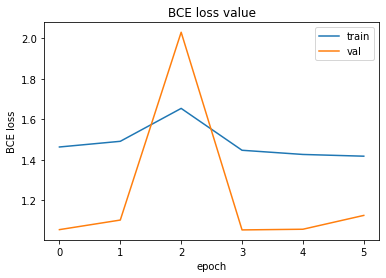

In [166]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

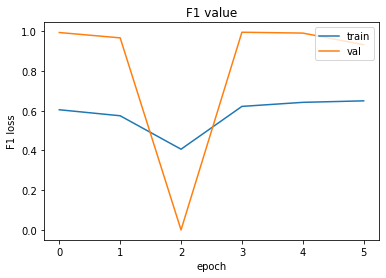

In [167]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 value')
plt.ylabel('F1 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

У меня ничего не сработало, здоровья пошибшим